# Addressing Imbalanced dataset problem with oversampling (SMOTE)

We have an imbalanced dataset and we will compare SMOTE versus standard ML models to see if there is any improvement.

**Don’t Put Too Much Stock Into ROC Curves**
For many classification problems, we look at the ROC (receiver operating characteristic) curve and the AUC (area under the curve). Intuitively, this tells us how much we ‘pay’ in false positives to achieve true positives. However, for class imbalance, if the positive class is the rare one, false positives aren’t the problem: false negatives are. Thus we should be careful of putting too much stock into ROC curves when dealing with imbalanced datasets.

In [36]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [3]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [5]:
df1 = pd.read_csv('creditcard.csv', delimiter=',')
df1.dataframeName = 'creditcard.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 284807 rows and 31 columns


<ipython-input-2-0121bf3d9d74>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)


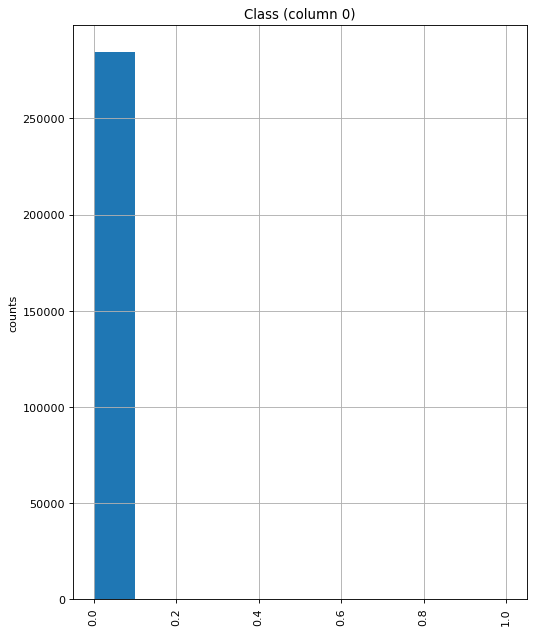

In [6]:
plotPerColumnDistribution(df1, 10, 5)

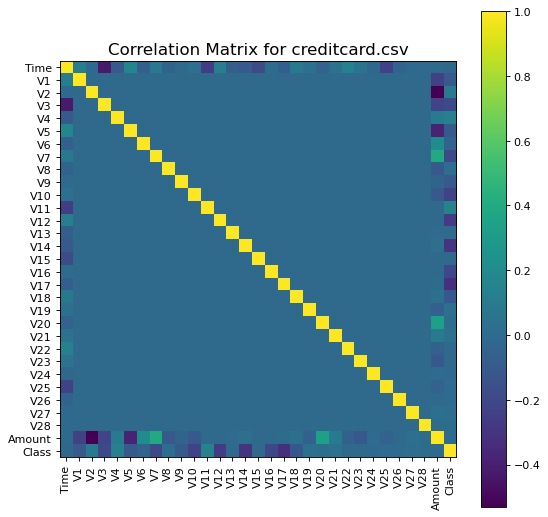

In [7]:
plotCorrelationMatrix(df1, 8)

In [13]:
from scipy.stats import ks_2samp
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

In [14]:
df = df1
df.drop(columns=["Time"], inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
(df.Class.value_counts(normalize=True)*100).rename("Classes' Proportions").to_frame()

,Classes' Proportions
0,99.827251
1,0.172749


In [51]:
X,y = df.drop(columns=["Class"]), df.Class
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=["Class"]), df.Class)


In [17]:
print(
    f"The positive class proportion in train set is {(Y_train == 1).sum() / Y_train.shape[0]:0.3f} \
whereas in test set is {(Y_test == 1).sum() / Y_test.shape[0]:.3f}"
)

The positive class proportion in train set is 0.002 whereas in test set is 0.002


# Standard machine learning

In [18]:
%%capture

xgb = XGBClassifier()
xgb.fit(X_train, Y_train)

preds = xgb.predict(X_test)
pred_probas = xgb.predict_proba(X_test)

In [19]:
c = confusion_matrix(Y_test, preds) / Y_test.shape[0] * 100
c = np.round(c, 2)

pd.DataFrame(
    c,
    columns=["Predicted Negative", "Predicted Positive"],
    index=["Negative Label", "Positive Label"]
)

,Predicted Negative,Predicted Positive
Negative Label,99.83,0.01
Positive Label,0.04,0.12


In [20]:
print(f"The Precision score was {precision_score(Y_test, preds):.2f}")

The Precision score was 0.95


Precision seems to be able to capture some of the imperfections on the model's predictions. However, it pays attention to the False Positive rate, a not so much important concept for the anomaly detection problem. Consequently, the final score still points to a considerably good solution.

In [21]:
print(f"The Recall score was {recall_score(Y_test, preds):.2f}")

The Recall score was 0.77


As well as Confusion Matrix, Recall seems to have been able to identify the main flaw in our classification model, i.e. its False Negative rate. Hence, in this regard, the model doesn't seem to be so powerful as pictured by the previous alternatives.

In [23]:
print(f"The AUC score was {roc_auc_score(Y_test.values, pred_probas[:, 1]):.2f}")

The AUC score was 0.98


Since the ROC curve displays the general performance of the model, it follows that the bigger the area under the resulting plot, the better will be the average performance of the model. If we normalize the Y-axis’ values, we will end up finding a figure with area ranging in the interval [0, 1]. The Area Under the ROC Curve (AUC) is a classification metric that succinctly expresses the probability that a classifier will give bigger importances to positive instances than to negative ones. A latent problem, however, is that the metric doesn’t express the model’s confidence level, only its correctness rate.

In [22]:
print(f"The F1 score was {f1_score(Y_test, preds):.2f}")

The F1 score was 0.85


Note that F1-score was capable of pointing to a possible flaw in the model. This is majorly because of the influence coming directly from the model's Recall.

# Oversampling

In [62]:
from sklearn.metrics import confusion_matrix
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Normal','Fraud']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

In [63]:
from sklearn.metrics import average_precision_score, precision_recall_curve
def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

C:\Users\mercos\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:38:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification of SMOTE-resampled dataset with XGboost


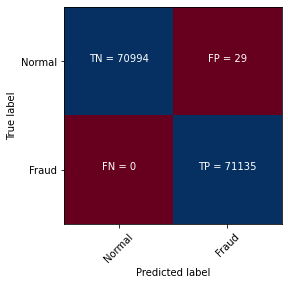

Recall=1.000 
Precision=1.000
F1=1.000
Average precision-recall score: 1.000


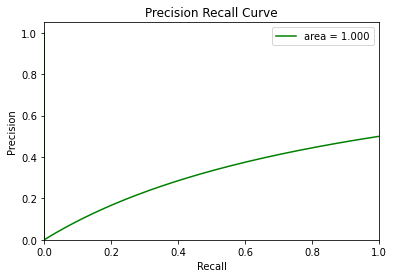

In [65]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, random_state = 42)

#fit the best models so far
xgb.fit(X_train, y_train)


#Make predictions
print('Classification of SMOTE-resampled dataset with XGboost')
y_pred = xgb.predict(X_test)
try:
    scores = xgb.decision_function(X_test)
except:
    scores = xgb.predict_proba(X_test)[:,1]
#Make plots
y_pred = xgb.predict(X_test)
plot_cm(xgb, y_pred)
plot_aucprc(xgb, scores)

In [67]:
print(f"The F1 score was {f1_score(y_test, y_pred):.2f}")

The F1 score was 1.00


Oversamling, SMOTE, helped us achieve a perfect F1 score.